Starting metric calculation...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading models...


Loading test data...
Calculating Model 1...
Calculating Model 2...
Calculating Model 3...
Calculating Model 4...
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Calculating Model 5...

--- PERFORMANCE METRICS ---
Copy these values into your app.py's `perf_data` dictionary:

| Model | Macro F1 | Log-Loss |
|---|---|---|
| Model 1 (Naive Bayes) | 0.515 | 0.513 |
Saved cm_model_1.png
| Model 2 (LogReg + TF-IDF) | 0.871 | 0.231 |
Saved cm_model_2.png
| Model 3 (LogReg + W2V) | 0.837 | 0.267 |
Saved cm_model_3.png
| Model 4 (LSTM) | 0.869 | 0.226 |
Saved cm_model_4.png
| Model 5 (DistilBERT) | 0.877 | 5.529 |
Saved cm_model_5.png

--- All metrics and charts generated! ---


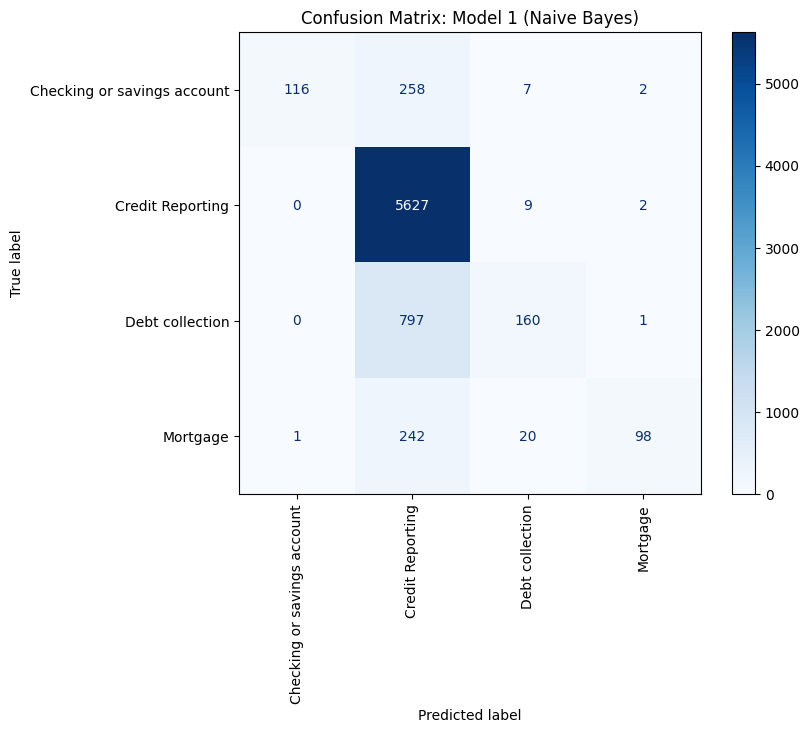

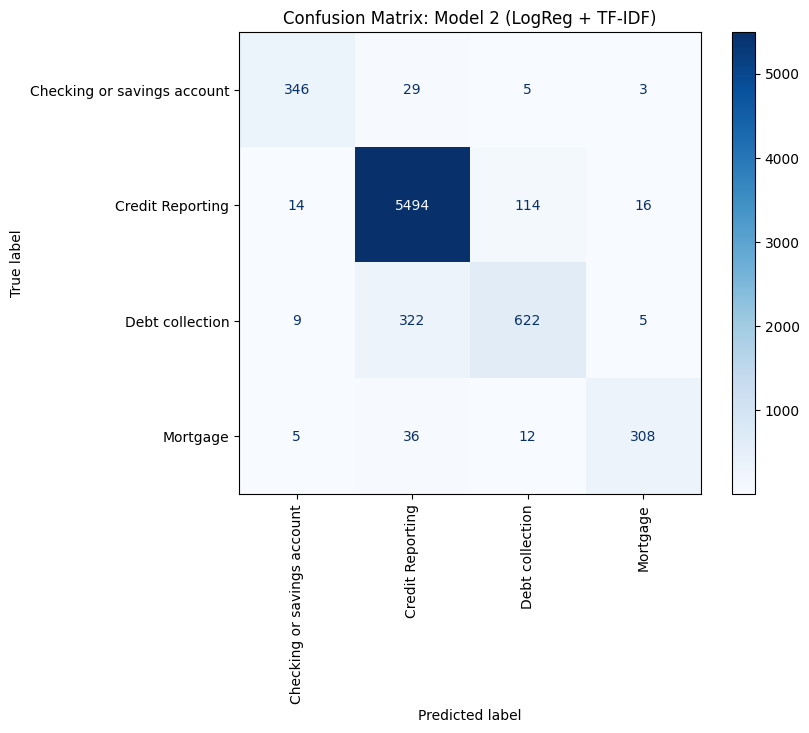

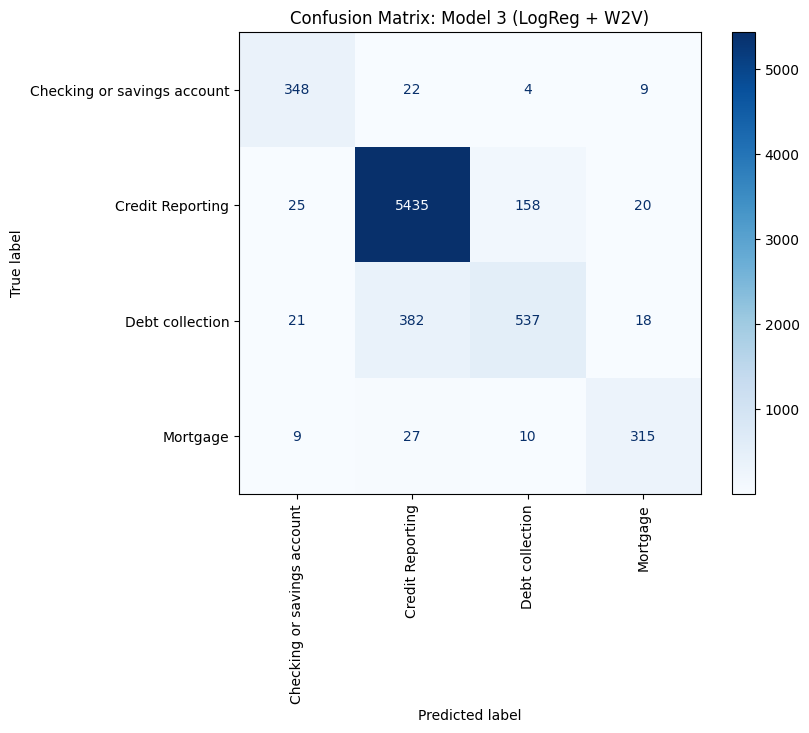

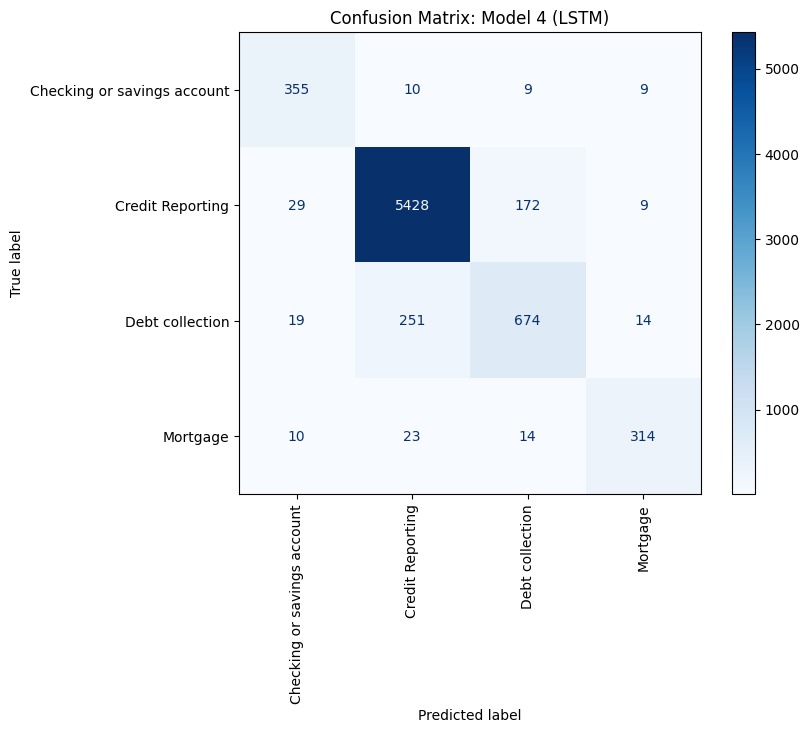

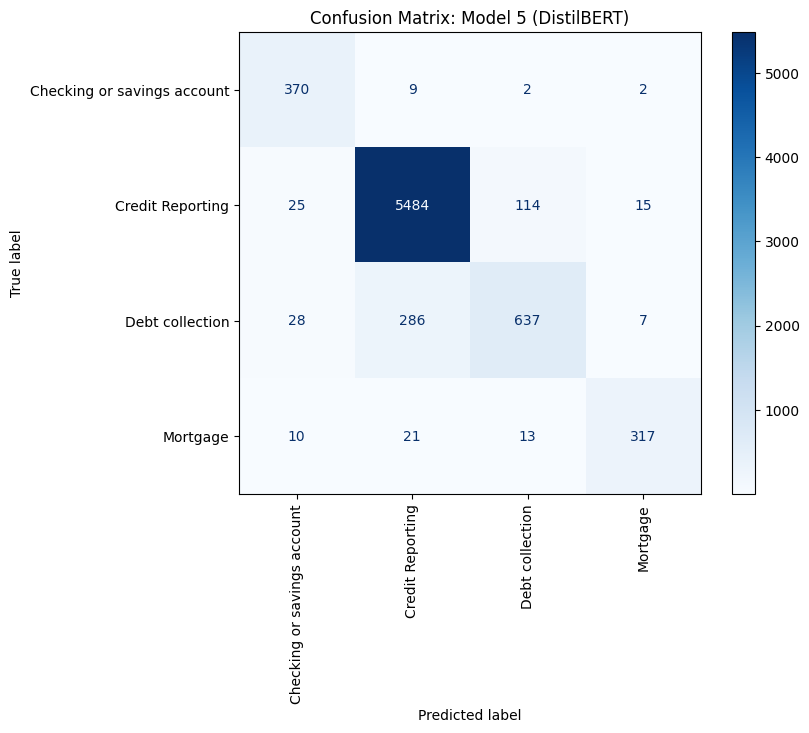

In [1]:
import pandas as pd
import numpy as np
import joblib
import gensim
import string
import nltk
import torch
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- 0. SETUP ---
warnings.filterwarnings('ignore')
print("Starting metric calculation...")

# --- Load NLTK data ---
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Define clean_text function BEFORE loading models ---
def clean_text(text):
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# --- 1. LOAD ALL 5 MODELS ---
print("Loading models...")
model_1 = joblib.load('model_1_nb.pkl')
CLASS_NAMES = list(model_1.classes_)
model_2 = joblib.load('model_2_lr.pkl')
w2v_model = gensim.models.Word2Vec.load('model_3_w2v.model')
model_3_lr = joblib.load('model_3_lr.pkl')
model_4_lstm = tf.keras.models.load_model('model_4_lstm.h5')
model_4_tokenizer = joblib.load('model_4_keras_tokenizer.pkl')
model_4_encoder = joblib.load('model_4_label_encoder.pkl')
model_dir = 'model_5_distilbert_final'
model_5_tokenizer = AutoTokenizer.from_pretrained(model_dir)
model_5_bert = AutoModelForSequenceClassification.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_5_bert.to(device)

# --- 2. LOAD FULL TEST DATA ---
print("Loading test data...")
df = pd.read_csv('complaints_final_clean.csv')
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['category'])
X_test_text = test_df['text'].tolist()
y_test_labels = test_df['category'].tolist()
y_test_numeric = model_4_encoder.transform(y_test_labels) # For LSTM

# --- 3. PREDICTION FUNCTIONS (for full test set) ---

def get_model_1_metrics():
    print("Calculating Model 1...")
    y_pred = model_1.predict(X_test_text)
    y_proba = model_1.predict_proba(X_test_text)
    return y_pred, y_proba

def get_model_2_metrics():
    print("Calculating Model 2...")
    y_pred = model_2.predict(X_test_text)
    y_proba = model_2.predict_proba(X_test_text)
    return y_pred, y_proba

def get_model_3_metrics():
    print("Calculating Model 3...")
    def vectorize(text_list, model):
        vectors = []
        for text in text_list:
            tokens = clean_text(text).split()
            word_vectors = [model.wv[word] for word in tokens if word in model.wv]
            if len(word_vectors) > 0:
                vectors.append(np.mean(word_vectors, axis=0))
            else:
                vectors.append(np.zeros(model.vector_size))
        return np.array(vectors)
    
    X_test_vecs = vectorize(X_test_text, w2v_model)
    y_pred = model_3_lr.predict(X_test_vecs)
    y_proba = model_3_lr.predict_proba(X_test_vecs)
    return y_pred, y_proba

def get_model_4_metrics():
    print("Calculating Model 4...")
    cleaned_texts = [clean_text(text) for text in X_test_text]
    seqs = model_4_tokenizer.texts_to_sequences(cleaned_texts)
    padded_seqs = pad_sequences(seqs, maxlen=150)
    y_proba = model_4_lstm.predict(padded_seqs, batch_size=64)
    y_pred_indices = np.argmax(y_proba, axis=1)
    y_pred = model_4_encoder.inverse_transform(y_pred_indices)
    return y_pred, y_proba

def get_model_5_metrics():
    print("Calculating Model 5...")
    all_preds = []
    all_probas = []
    batch_size = 64
    for i in range(0, len(X_test_text), batch_size):
        batch = X_test_text[i:i+batch_size]
        inputs = model_5_tokenizer(batch, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            logits = model_5_bert(**inputs).logits
        probas = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        preds_indices = torch.argmax(logits, dim=1).cpu().numpy()
        all_probas.extend(probas)
        all_preds.extend(preds_indices)
    
    y_pred = [model_5_bert.config.id2label[i] for i in all_preds]
    return y_pred, np.array(all_probas)

# --- 4. CALCULATE & PLOT EVERYTHING ---

model_metrics = {
    "Model 1 (Naive Bayes)": get_model_1_metrics(),
    "Model 2 (LogReg + TF-IDF)": get_model_2_metrics(),
    "Model 3 (LogReg + W2V)": get_model_3_metrics(),
    "Model 4 (LSTM)": get_model_4_metrics(),
    "Model 5 (DistilBERT)": get_model_5_metrics()
}

print("\n--- PERFORMANCE METRICS ---")
print("Copy these values into your app.py's `perf_data` dictionary:\n")
print("| Model | Macro F1 | Log-Loss |")
print("|---|---|---|")

for i, (name, (y_pred, y_proba)) in enumerate(model_metrics.items()):
    # Get Macro F1
    report = classification_report(y_test_labels, y_pred, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']
    
    # Get Log Loss
    # We must ensure the labels for log_loss are in the correct order
    loss = log_loss(y_test_labels, y_proba, labels=CLASS_NAMES)
    
    print(f"| {name} | {macro_f1:.3f} | {loss:.3f} |")
    
    # Generate and Save Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test_labels, y_pred, labels=CLASS_NAMES)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    ax.set_title(f"Confusion Matrix: {name}")
    
    # Save the figure
    img_filename = f"cm_model_{i+1}.png"
    fig.savefig(img_filename, bbox_inches='tight')
    print(f"Saved {img_filename}")

print("\n--- All metrics and charts generated! ---")